In [1]:
# Insert code here.
import pandas as pd
import numpy as np
import random
import re
import time
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neighbors
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, BertConfig
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
# from sentence_transformers import SentenceTransformer
# sent_encoder = SentenceTransformer('bert-base-nli-mean-tokens')

In [2]:
models = ['bert-base-uncased', 'distilbert-base-uncased-finetuned-sst-2-english', 'textattack/roberta-base-SST-2', 'monologg/electra-small-finetuned-imdb', 'google/electra-base-discriminator', 'xlnet-base-cased', 'xlm-roberta-large']
model_num = 2
tokenizer = AutoTokenizer.from_pretrained(models[model_num])


In [3]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:1")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
torch.cuda.empty_cache()

There are 3 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [4]:
DATASET_PATH = '../datasets/nela-gt/nela10.csv'

In [5]:
df = pd.read_csv(DATASET_PATH)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 57,157



,id,date,source,title,content,author,url,published,published_utc,collection_utc,Reliability
42589,usatoday--2019-06-27--Thataposs a wrap First n...,2019-06-27,usatoday,That&apos;s a wrap: First night of the Democra...,Ten Democratic presidential candidates spent t...,"John Fritze, Michael Collins and Maureen Gropp...",http://rssfeeds.usatoday.com/~/603658820/0/usa...,2019-06-27 04:26:34+00:00,1561623994,1567537829,0
54082,theduran--2019-01-30--Venezuelan Prosecutor Ge...,2019-01-30,theduran,Venezuelan Prosecutor General Says Eager to Op...,Venezuela's Prosecutor General Tarek Saab stat...,Sputnik News Service,https://sputniknews.com/latam/2019012910719318...,2019-01-30 00:38:50+00:00,1548826730,1567550299,2
2096,bbc--2019-08-25--Trailer and date of Breaking ...,2019-08-25,bbc,Trailer and date of Breaking Bad film released,Fans of Breaking Bad will only have to wait un...,NaN,https://www.bbc.co.uk/news/newsbeat-49445008,2019-08-25 10:17:26+00:00,1566742646,1567533433,0
3158,bbcuk--2019-02-22--Web watchdog warns over kne...,2019-02-22,bbcuk,Web watchdog warns over knee-jerk regulation o...,Government regulation of social media and the ...,NaN,https://www.bbc.co.uk/news/technology-47321541,2019-02-22 00:11:47+00:00,1550812307,1567547695,0
385,aljazeera--2019-04-07--How the courage of a fe...,2019-04-07,aljazeera,How the courage of a few Rwandan women changed...,"Long before Twitter, Harvey Weinstein, and #Me...",NaN,https://www.aljazeera.com/indepth/opinion/cour...,2019-04-07 09:47:51+00:00,1554644871,1567543700,0
53409,sottnet--2019-09-16--Shocking traffic Lightnin...,2019-09-16,sottnet,Shocking traffic: Lightning strikes car twice ...,I find that when people are truly searching to...,NaN,https://www.sott.net/article/420470-Shocking-t...,2019-09-16 15:46:33+00:00,1568663193,1569008597,2
28843,thehill--2019-01-09--Fox News Shep Smith fact-...,2019-01-09,thehill,Fox News’ Shep Smith fact-checks Trump address,Fox News anchor Shepard Smith fact-checked Pre...,Morgan Gstalter,https://thehill.com/homenews/media/424474-fox-...,2019-01-09 03:13:40+00:00,1547021620,1567553367,0
34576,theindependent--2019-09-10--Woman jailed for p...,2019-09-10,theindependent,Woman jailed for punching Muslim woman and rip...,A care assistant has been jailed for 20 months...,Colin Drury,https://www.independent.co.uk/news/uk/crime/wo...,2019-09-10 12:31:42+00:00,1568133102,1569330545,0
47937,globalresearch--2019-02-22--Quantitative Easin...,2019-02-22,globalresearch,Quantitative Easing (QE) Forever: The Fed’s Dr...,“Quantitative easing” was supposed to be an em...,Ellen Brown,https://www.globalresearch.ca/quantitative-eas...,2019-02-22 11:55:52+00:00,1550854552,1567547638,2
47474,dailymail--2019-09-13--Hell yes we ARE going t...,2019-09-13,dailymail,"'Hell yes, we ARE going to take your AR-15s!' ...",Beto O'Rourke made a bold gun control vow Thur...,NaN,https://www.dailymail.co.uk/news/article-74590...,2019-09-13 11:26:06+00:00,1568388366,1569330315,2


In [6]:
def count_words(text):
    try:
        return len(text.split())
    except:
        print(text)
        return None
def change_rel(num):
    if num == 2:
        return 1
    else:
        return 0

In [7]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = []

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
#     text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['title'] = df['title'].apply(clean_text)
df['title'] = df['title'].str.replace('\d+', '')
df['Reliability'] = df['Reliability'].apply(change_rel)

In [8]:
df['title'].apply(count_words).max()

30

In [9]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['title'], df['Reliability'], test_size=0.2, stratify=df['Reliability'])

In [10]:
MAX_LENGTH = 40
posts = train_x.values
categories = train_y.values

In [11]:
encoded_dict = tokenizer.encode_plus(
                        posts[0],                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
encoded_dict

/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([[    0,  2603,    29,  1368,   833,  9953,  1717,   890,  2550,  3553,
         13206,   254,   524,   196,   910,  7198,   295,   705,  4560,     7,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [12]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

In [13]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.875 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


40,009 training samples
5,716 validation samples


In [14]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [15]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    models[model_num], # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [16]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

In [17]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [18]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [20]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [21]:
seed_val = 63
torch.cuda.empty_cache()
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    if epoch_i >= 1:
        inp = input()
        if inp.startswith('y'):
            break

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,251.    Elapsed: 0:00:04.
  Batch    80  of  1,251.    Elapsed: 0:00:08.
  Batch   120  of  1,251.    Elapsed: 0:00:12.
  Batch   160  of  1,251.    Elapsed: 0:00:16.
  Batch   200  of  1,251.    Elapsed: 0:00:20.
  Batch   240  of  1,251.    Elapsed: 0:00:24.
  Batch   280  of  1,251.    Elapsed: 0:00:28.
  Batch   320  of  1,251.    Elapsed: 0:00:32.
  Batch   360  of  1,251.    Elapsed: 0:00:36.
  Batch   400  of  1,251.    Elapsed: 0:00:40.
  Batch   440  of  1,251.    Elapsed: 0:00:44.
  Batch   480  of  1,251.    Elapsed: 0:00:48.
  Batch   520  of  1,251.    Elapsed: 0:00:53.
  Batch   560  of  1,251.    Elapsed: 0:00:57.
  Batch   600  of  1,251.    Elapsed: 0:01:01.
  Batch   640  of  1,251.    Elapsed: 0:01:05.
  Batch   680  of  1,251.    Elapsed: 0:01:09.
  Batch   720  of  1,251.    Elapsed: 0:01:13.
  Batch   760  of  1,251.    Elapsed: 0:01:17.
  Batch   800  of  1,251.    Elapsed: 0:01:21.
  Batch   840  of

 n



======== Epoch 3 / 4 ========
Training...
  Batch    40  of  1,251.    Elapsed: 0:00:04.
  Batch    80  of  1,251.    Elapsed: 0:00:08.
  Batch   120  of  1,251.    Elapsed: 0:00:12.
  Batch   160  of  1,251.    Elapsed: 0:00:16.
  Batch   200  of  1,251.    Elapsed: 0:00:20.
  Batch   240  of  1,251.    Elapsed: 0:00:24.
  Batch   280  of  1,251.    Elapsed: 0:00:28.
  Batch   320  of  1,251.    Elapsed: 0:00:32.
  Batch   360  of  1,251.    Elapsed: 0:00:36.
  Batch   400  of  1,251.    Elapsed: 0:00:40.
  Batch   440  of  1,251.    Elapsed: 0:00:45.
  Batch   480  of  1,251.    Elapsed: 0:00:49.
  Batch   520  of  1,251.    Elapsed: 0:00:53.
  Batch   560  of  1,251.    Elapsed: 0:00:57.
  Batch   600  of  1,251.    Elapsed: 0:01:01.
  Batch   640  of  1,251.    Elapsed: 0:01:05.
  Batch   680  of  1,251.    Elapsed: 0:01:09.
  Batch   720  of  1,251.    Elapsed: 0:01:13.
  Batch   760  of  1,251.    Elapsed: 0:01:17.
  Batch   800  of  1,251.    Elapsed: 0:01:21.
  Batch   840  of

 y



Training complete!
Total training took 0:13:43 (h:mm:ss)


In [22]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.""
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.41,0.38,0.81,0:02:08,0:00:05
2,0.33,0.36,0.83,0:02:09,0:00:05
3,0.27,0.38,0.84,0:02:08,0:00:05


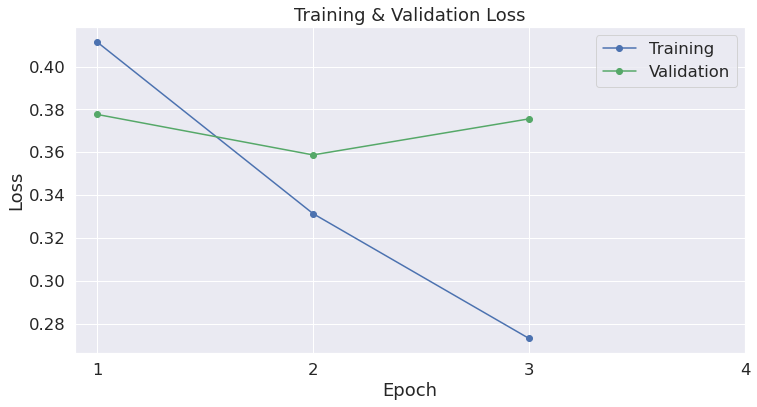

In [23]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [24]:
posts = valid_x.values
categories = valid_y.values

In [25]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

# Set the batch size.  
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 11,432 test sentences...
    DONE.


In [27]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
predicts = []
accurate = 0
total_len = 0
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    predicts.append(pred_labels_i)
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)

    matthews_set.append(matthews)
    for j in range(len(true_labels[i])):
        if true_labels[i][j] == pred_labels_i[j]:
            accurate+=1
        total_len+=1
print("Accuracy:",accurate/total_len)

Calculating Matthews Corr. Coef. for each batch...
Accuracy: 0.844034289713086


In [28]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8917
           1       0.69      0.54      0.60      2515

    accuracy                           0.84     11432
   macro avg       0.78      0.73      0.75     11432
weighted avg       0.83      0.84      0.84     11432



In [31]:
torch.save(model, '/scratch/tathagataraha/nela-gt-title-roberta.pt')